<a href="https://colab.research.google.com/github/roshankenia/RANSAC/blob/main/RANSAC_v2_Identifier_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import random
import numpy as np

from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2D, GlobalMaxPooling2D, MaxPooling2D
from keras.models import Model
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler

In [2]:
#method to add noisy labels to data
def corruptData(trainY, testY, noisePercentage):
  #create copies of labels
  copyTrainY = trainY.copy()
  copyTestY = testY.copy()

  #calculate number of samples to be made noisy
  numberNoisyTrain = int(noisePercentage * len(copyTrainY))
  numberNoisyTest = int(noisePercentage * len(copyTestY))

  #generate indexes to swap
  trainYSwitchIndexes = random.sample(range(0, len(copyTrainY)), numberNoisyTrain)
  testYSwitchIndexes = random.sample(range(0, len(copyTestY)), numberNoisyTest)

  #generate new classes not equal to original for training and switch class
  for i in range(len(trainYSwitchIndexes)):
    label = random.choice(range(10))
    #find label that isn't the same
    while label == trainY[trainYSwitchIndexes[i]]:
      label = random.choice(range(10))
    #switch label
    copyTrainY[trainYSwitchIndexes[i]] = label

  #generate new classes not equal to original for testing and switch class
  for i in range(len(testYSwitchIndexes)):
    label = random.choice(range(10))
    #find label that isn't the same
    while label == testY[testYSwitchIndexes[i]]:
      label = random.choice(range(10))
    #switch label
    copyTestY[testYSwitchIndexes[i]] = label

  return (copyTrainY, copyTestY)

In [3]:
def splitTrainingData(trainX, trainY, splitPercentage):
  #get number of elements to split
  numberSplit = int(splitPercentage * len(trainX))
  #generate indexes to split
  indexes = list(range(len(trainX)))
  beforeSplitIndexes = random.sample(range(0, len(trainX)), numberSplit)
  afterSplitIndexes = list(set(indexes)-set(beforeSplitIndexes))

  #make new arrays
  firstTrainX = []
  firstTrainY = []
  secondTrainX = []
  secondTrainY = []

  #add each data sample to corresponding list
  for index in beforeSplitIndexes:
    firstTrainX.append(trainX[index])
    firstTrainY.append(trainY[index])
  for index in afterSplitIndexes:
    secondTrainX.append(trainX[index])
    secondTrainY.append(trainY[index])      
  return np.array(firstTrainX), np.array(firstTrainY), np.array(secondTrainX), np.array(secondTrainY)

In [4]:
def trainModel(trainX, trainY, n):
  #pre-train the model

  # number of classes
  K = 10

  # calculate total number of classes
  # for output layer
  print("number of classes:", K)

  # Build the model using the functional API
  # input layer
  i = Input(shape=trainX[0].shape)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)

  if n == 2:
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

  if n == 3:
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.2)(x)

  # Hidden layer
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)

  # last hidden layer i.e.. output layer
  x = Dense(K, activation='softmax')(x)

  model = Model(i, x)

  # model description
  # model.summary()

  # Compile
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # Fit
  r = model.fit(trainX, trainY, epochs=20)

  return model

In [5]:
from scipy.stats import entropy
def makeConfidentTrainingSets(model, firstTrainX, firstTrainY, secondTrainX, secondTrainY, percentageOfMean):
  #find confident samples from first training set
  #obtain probability distribution of classes for each sample after the split and calculate its entropy
  #make predictions
  firstTrainXPredictions = model.predict(firstTrainX)
  #find entropy and peak value for every sample
  firstTrainXEntropies = []
  firstTrainXPeakValues = []
  for sample in firstTrainXPredictions:
    #calculate entropy
    sampleEntropy = entropy(sample)
    #calculate peak value
    probSorted = sorted(sample)
    peakValue = probSorted[0]/probSorted[1]

    firstTrainXEntropies.append(sampleEntropy)
    firstTrainXPeakValues.append(peakValue)

  #set NANs to 0
  firstTrainXPeakValues = np.array(firstTrainXPeakValues)
  firstTrainXPeakValues[np.isnan(firstTrainXPeakValues)] = 0
  #calculate mean of entropy and peak value
  meanEntropy = np.mean(firstTrainXEntropies)
  meanPeakValue = np.mean(firstTrainXPeakValues)

  #entropy and peak value hyperparameter
  entropyVal = percentageOfMean*meanEntropy
  peakVal = percentageOfMean*meanPeakValue

  #obtain samples that were correctly predicted and fall under the threshold for entropy and peak value
  confidentFirstTrainX = []
  confidentFirstTrainY = []

  for i in range(len(firstTrainXPredictions)):
    probDist = firstTrainXPredictions[i]
    predictedClass = np.argmax(probDist)

    #if confident add to list
    if predictedClass == firstTrainY[i] and firstTrainXEntropies[i] <= entropyVal and firstTrainXPeakValues[i] > peakVal:
      confidentFirstTrainX.append(firstTrainX[i])
      confidentFirstTrainY.append(firstTrainY[i])



  #find confident samples from unused training set
  #obtain probability distribution of classes for each sample after the split and calculate its entropy
  #make predictions
  secondTrainXPredictions = model.predict(secondTrainX)
  #find entropy and peak value for every sample
  secondTrainXEntropies = []
  secondTrainXPeakValues = []
  for sample in secondTrainXPredictions:
    #calculate entropy
    sampleEntropy = entropy(sample)
    #calculate peak value
    probSorted = sorted(sample)
    peakValue = probSorted[0]/probSorted[1]

    secondTrainXEntropies.append(sampleEntropy)
    secondTrainXPeakValues.append(peakValue)

  #set NANs to 0
  secondTrainXPeakValues = np.array(secondTrainXPeakValues)
  secondTrainXPeakValues[np.isnan(secondTrainXPeakValues)] = 0

  #calculate mean of entropy and peak value
  meanEntropy = np.mean(secondTrainXEntropies)
  meanPeakValue = np.mean(secondTrainXPeakValues)

  #entropy and peak value hyperparameter
  entropyVal = percentageOfMean*meanEntropy
  peakVal = percentageOfMean*meanPeakValue

  #obtain samples that were correctly predicted and fall under the threshold for entropy and peak value
  confidentSecondTrainX = []
  confidentSecondTrainY = []

  for i in range(len(secondTrainXPredictions)):
    probDist = secondTrainXPredictions[i]
    predictedClass = np.argmax(probDist)

    #if confident add to list
    if predictedClass == secondTrainY[i] and secondTrainXEntropies[i] <= entropyVal and secondTrainXPeakValues[i] > peakVal:
      confidentSecondTrainX.append(secondTrainX[i])
      confidentSecondTrainY.append(secondTrainY[i])

  #combine confident samples together
  newTrainX = np.concatenate((confidentFirstTrainX, confidentSecondTrainX))
  newTrainY = np.concatenate((confidentFirstTrainY, confidentSecondTrainY))

  return newTrainX, newTrainY

In [6]:
#find out how much of corrupted test data the model can correctly predict
def accuracyWithMislabeled(ransac_model, testX, testY, testYMislabeled):
  predictions = ransac_model.predict(testX)
  correctlyPredicted = 0
  normalCount = 0
  correctlyIdentified = 0
  corruptedCount = 0
  for i in range(len(testY)):
    #obtain prediction
    prediction = np.argmax(predictions[i])

    #check if not corrupted and correctly predicted
    if testYMislabeled[i] == testY[i]:
      normalCount+=1
      if prediction == testY[i]:
        correctlyPredicted += 1
    #check if corruped and correctly identified
    elif testYMislabeled[i] != testY[i]:
      corruptedCount += 1
      if prediction == testY[i]:
        correctlyIdentified +=1

  return correctlyPredicted, normalCount, correctlyIdentified, corruptedCount

In [7]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

#Normalize pixel values to be between 0 and 1
trainX, testX = trainX / 255.0, testX / 255.0

#flatten the label values
trainY, testY = trainY.flatten(), testY.flatten()

#corrupt data
noisePercentage = 0.25
trainYMislabeled, testYMislabeled = corruptData(trainY, testY, noisePercentage)

#split data
splitPercentage = .7
firstTrainX, firstTrainY, secondTrainX, secondTrainY = splitTrainingData(trainX, trainYMislabeled, splitPercentage)

170508288/170498071 [==============================] - 3s 0us/step


In [10]:
#first train a clean model on clean data to get an upperbound
cleanModel = trainModel(trainX, trainY, 1)

number of classes: 10
Epoch 1/20
1563/1563 [==============================] - 20s 12ms/step - loss: 1.4373 - accuracy: 0.5151
Epoch 2/20
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0168 - accuracy: 0.6463
Epoch 3/20
1563/1563 [==============================] - 19s 12ms/step - loss: 0.8331 - accuracy: 0.7091
Epoch 4/20
1563/1563 [==============================] - 20s 13ms/step - loss: 0.6776 - accuracy: 0.7650
Epoch 5/20
1563/1563 [==============================] - 19s 12ms/step - loss: 0.5411 - accuracy: 0.8121
Epoch 6/20
1563/1563 [==============================] - 20s 13ms/step - loss: 0.4296 - accuracy: 0.8532
Epoch 7/20
1563/1563 [==============================] - 19s 12ms/step - loss: 0.3506 - accuracy: 0.8782
Epoch 8/20
1563/1563 [==============================] - 19s 12ms/step - loss: 0.2887 - accuracy: 0.9027
Epoch 9/20
1563/1563 [==============================] - 19s 12ms/step - loss: 0.2466 - accuracy: 0.9173
Epoch 10/20
1563/1563 [===================

In [14]:
upperBoundAccuracy = cleanModel.evaluate(testX, testY)[1]

print(upperBoundAccuracy)

313/313 [==============================] - 2s 6ms/step - loss: 1.5540 - accuracy: 0.6776
0.6776000261306763


In [ ]:
#run experiments

percentageOfMeans = [2, 2.25, 2.5, 2.75, 3]
performances = []
#train model used to identify confident samples
confidenceModel = trainModel(firstTrainX, firstTrainY, 1)
for mean in percentageOfMeans:
  #find samples that this model is confident on
  newTrainX, newTrainY = makeConfidentTrainingSets(confidenceModel, firstTrainX, firstTrainY, secondTrainX, secondTrainY, mean)

  #train a new model on these confident samples
  ransacModel = trainModel(newTrainX, newTrainY, 1)

  #calculate accuracy of this model in identifying corrupted samples
  correctlyPredicted, normalCount, correctlyIdentified, corruptedCount = accuracyWithMislabeled(ransacModel, testX, testY, testYMislabeled)

  #add performance
  modelPerformance = (mean, correctlyPredicted, normalCount, correctlyIdentified, corruptedCount)
  performances.append(modelPerformance)

number of classes: 10
Epoch 1/20
1094/1094 [==============================] - 16s 6ms/step - loss: 1.8650 - accuracy: 0.3986
Epoch 2/20
1094/1094 [==============================] - 6s 6ms/step - loss: 1.5078 - accuracy: 0.5143
Epoch 3/20
1094/1094 [==============================] - 6s 6ms/step - loss: 1.3599 - accuracy: 0.5725
Epoch 4/20
1094/1094 [==============================] - 6s 6ms/step - loss: 1.2242 - accuracy: 0.6181
Epoch 5/20
1094/1094 [==============================] - 6s 6ms/step - loss: 1.0731 - accuracy: 0.6681
Epoch 6/20
1094/1094 [==============================] - 7s 6ms/step - loss: 0.9141 - accuracy: 0.7164
Epoch 7/20
1094/1094 [==============================] - 6s 6ms/step - loss: 0.7608 - accuracy: 0.7633
Epoch 8/20
1094/1094 [==============================] - 6s 6ms/step - loss: 0.6257 - accuracy: 0.8051
Epoch 9/20
1094/1094 [==============================] - 6s 6ms/step - loss: 0.5264 - accuracy: 0.8332
Epoch 10/20
1094/1094 [==============================] - 6s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in float_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in float_scalars


number of classes: 10
Epoch 1/20
998/998 [==============================] - 6s 6ms/step - loss: 1.6847 - accuracy: 0.4860
Epoch 2/20
998/998 [==============================] - 6s 6ms/step - loss: 1.2316 - accuracy: 0.6146
Epoch 3/20
998/998 [==============================] - 6s 6ms/step - loss: 1.0610 - accuracy: 0.6725
Epoch 4/20
998/998 [==============================] - 6s 6ms/step - loss: 0.9018 - accuracy: 0.7228
Epoch 5/20
998/998 [==============================] - 6s 6ms/step - loss: 0.7308 - accuracy: 0.7751
Epoch 6/20
998/998 [==============================] - 6s 6ms/step - loss: 0.5768 - accuracy: 0.8201
Epoch 7/20
998/998 [==============================] - 6s 6ms/step - loss: 0.4607 - accuracy: 0.8538
Epoch 8/20
998/998 [==============================] - 6s 6ms/step - loss: 0.3704 - accuracy: 0.8812
Epoch 9/20
998/998 [==============================] - 6s 6ms/step - loss: 0.3092 - accuracy: 0.9025
Epoch 10/20
998/998 [==============================] - 6s 6ms/step - loss: 0.2


This model used a percentage of mean of: 2
This model was able to correctly predict 5760 samples out of 9000
This model was able to correctly identify 612 mislabeled samples out of 1000
Adding in the correctly identified mislabeled samples this model had an accuracy of 0.6372

This model used a percentage of mean of: 2.25
This model was able to correctly predict 5695 samples out of 9000
This model was able to correctly identify 622 mislabeled samples out of 1000
Adding in the correctly identified mislabeled samples this model had an accuracy of 0.6317

This model used a percentage of mean of: 2.5
This model was able to correctly predict 5827 samples out of 9000
This model was able to correctly identify 633 mislabeled samples out of 1000
Adding in the correctly identified mislabeled samples this model had an accuracy of 0.646

This model used a percentage of mean of: 2.75
This model was able to correctly predict 5834 samples out of 9000
This model was able to correctly identify 627 mis

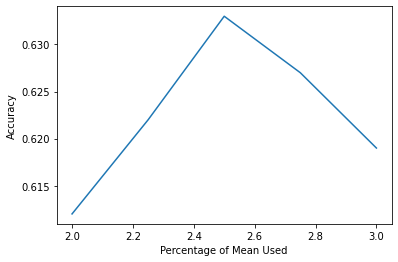

In [ ]:
mislabeledIdentified = []
for performance in performances:
  print('\nThis model used a percentage of mean of:', performance[0])
  print("This model was able to correctly predict",performance[1],"samples out of",performance[2])
  print("This model was able to correctly identify",performance[3],"mislabeled samples out of",performance[4])
  print("Adding in the correctly identified mislabeled samples this model had an accuracy of",((performance[1]+performance[3])/len(testY)))

  mislabeledIdentified.append((performance[3]/performance[4]))

plt.plot(percentageOfMeans, mislabeledIdentified)
plt.xlabel('Percentage of Mean Used')
plt.ylabel('Mislabeled Identified')
plt.show()

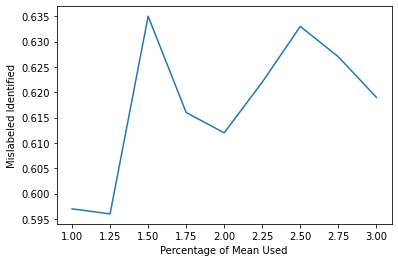

In [ ]:
percentages = [1,1.25,1.5,1.75,2,2.25, 2.5, 2.75, 3]
identified = [.597, .596, .635, .616, .612, .622, .633, .627, .619]\

plt.plot(percentages, identified)
plt.xlabel('Percentage of Mean Used')
plt.ylabel('Mislabeled Identified')
plt.show()